In [87]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.metrics import classification_report


from tsfresh import extract_relevant_features
from eli5 import show_weights

1. Чтение датасета об информации о раке груди. Необходимо по независимым признакам спрогнозировать есть рак или нет

In [88]:
from sklearn import datasets
data = datasets.load_breast_cancer()
X = pd.DataFrame(data["data"], columns=data["feature_names"])[:230]

In [89]:
y = pd.DataFrame(data["target"], columns=["target"])[:230]

 2.  Cтатистика данных

In [90]:
def isnull(data):
    return  data.isnull().sum()
def min_data(data):
    return  data.min()
def median(data):
    return  data.median()
def mean(data):
    return  round(data.mean(), 2)
def max_data(data):
    return  data.max()
def quantile_25(data):
    return  data.quantile(0.25)
def quantile_75(data):
    return  data.quantile(0.75)


func = [isnull, min_data, median, mean, max_data, quantile_25, quantile_75]

In [91]:
statistic_data = X.agg(func)
# print(statistic_data)

Доля заболевания

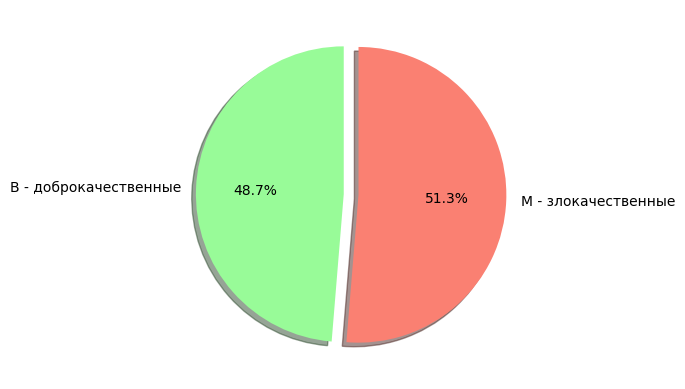

In [92]:
y_count = y.value_counts()
labels = ['B - доброкачественные', 'M - злокачественные']
sizes = [y_count[1], y_count[0]]
explode = (0, 0.1)
colors = ['palegreen', 'salmon']

fig, ax = plt.subplots()
ax.pie(sizes, colors =colors, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

plt.show()

3. Подготовка датасета к построению моделей ML

In [93]:
# a. Провести анализ и обработку пропусков

print(X.isnull().sum())
print("\nВ данных нет пропусков")

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
dtype: int64

В данных нет пропусков


In [94]:
def show_boxplot(data, columns):
    plt.figure(figsize=(20,10))
    
    for i,col in enumerate(columns):
        plt.subplot(5,6,i + 1)
        sns.boxplot(y=col, data=data)
    plt.tight_layout()
    plt.show()

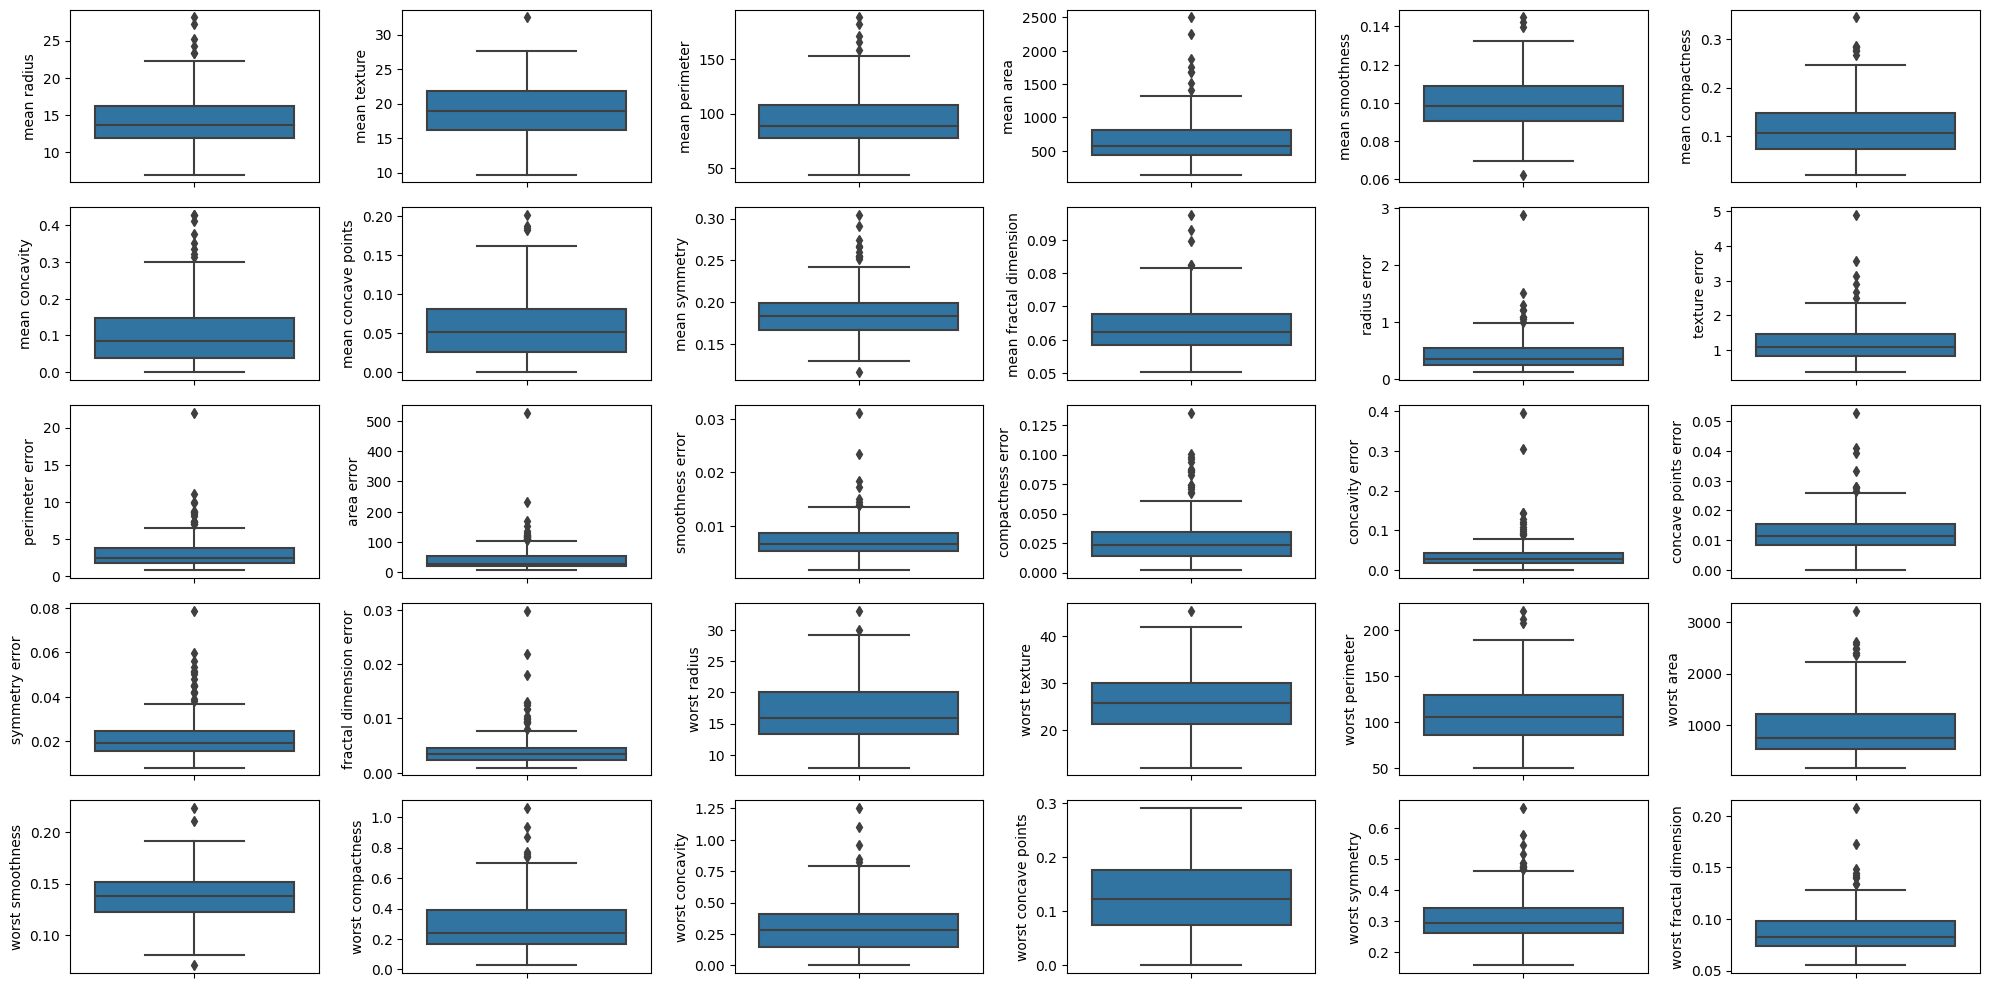

In [95]:
show_boxplot(X, X.columns)

Удалиение выбросов интерквартильным методом

In [96]:
def remove_value(data, y):
    for col in data.columns:
        print(col)
        quantile_25 = data[col].quantile(0.25)
        quantile_75 = data[col].quantile(0.75)
        iqr = quantile_75 - quantile_25
        min_value = quantile_25 - (2 * iqr)
        max_value = quantile_75 + (2 * iqr)
#         print(round(min_value,2), round(max_value, 2))
        index_to_drop = data[(data[col] < min_value) | (data[col] > max_value)].index
        print(len(index_to_drop))
        data = data.drop(index_to_drop)
        y = y.drop(index_to_drop)
    return data, y

In [97]:
X, y = remove_value(X, y)

mean radius
3
mean texture
0
mean perimeter
1
mean area
2
mean smoothness
1
mean compactness
4
mean concavity
1
mean concave points
0
mean symmetry
3
mean fractal dimension
1
radius error
4
texture error
3
perimeter error
2
area error
8
smoothness error
2
compactness error
6
concavity error
1
concave points error
0
symmetry error
3
fractal dimension error
3
worst radius
1
worst texture
0
worst perimeter
0
worst area
1
worst smoothness
1
worst compactness
1
worst concavity
0
worst concave points
0
worst symmetry
4
worst fractal dimension
2


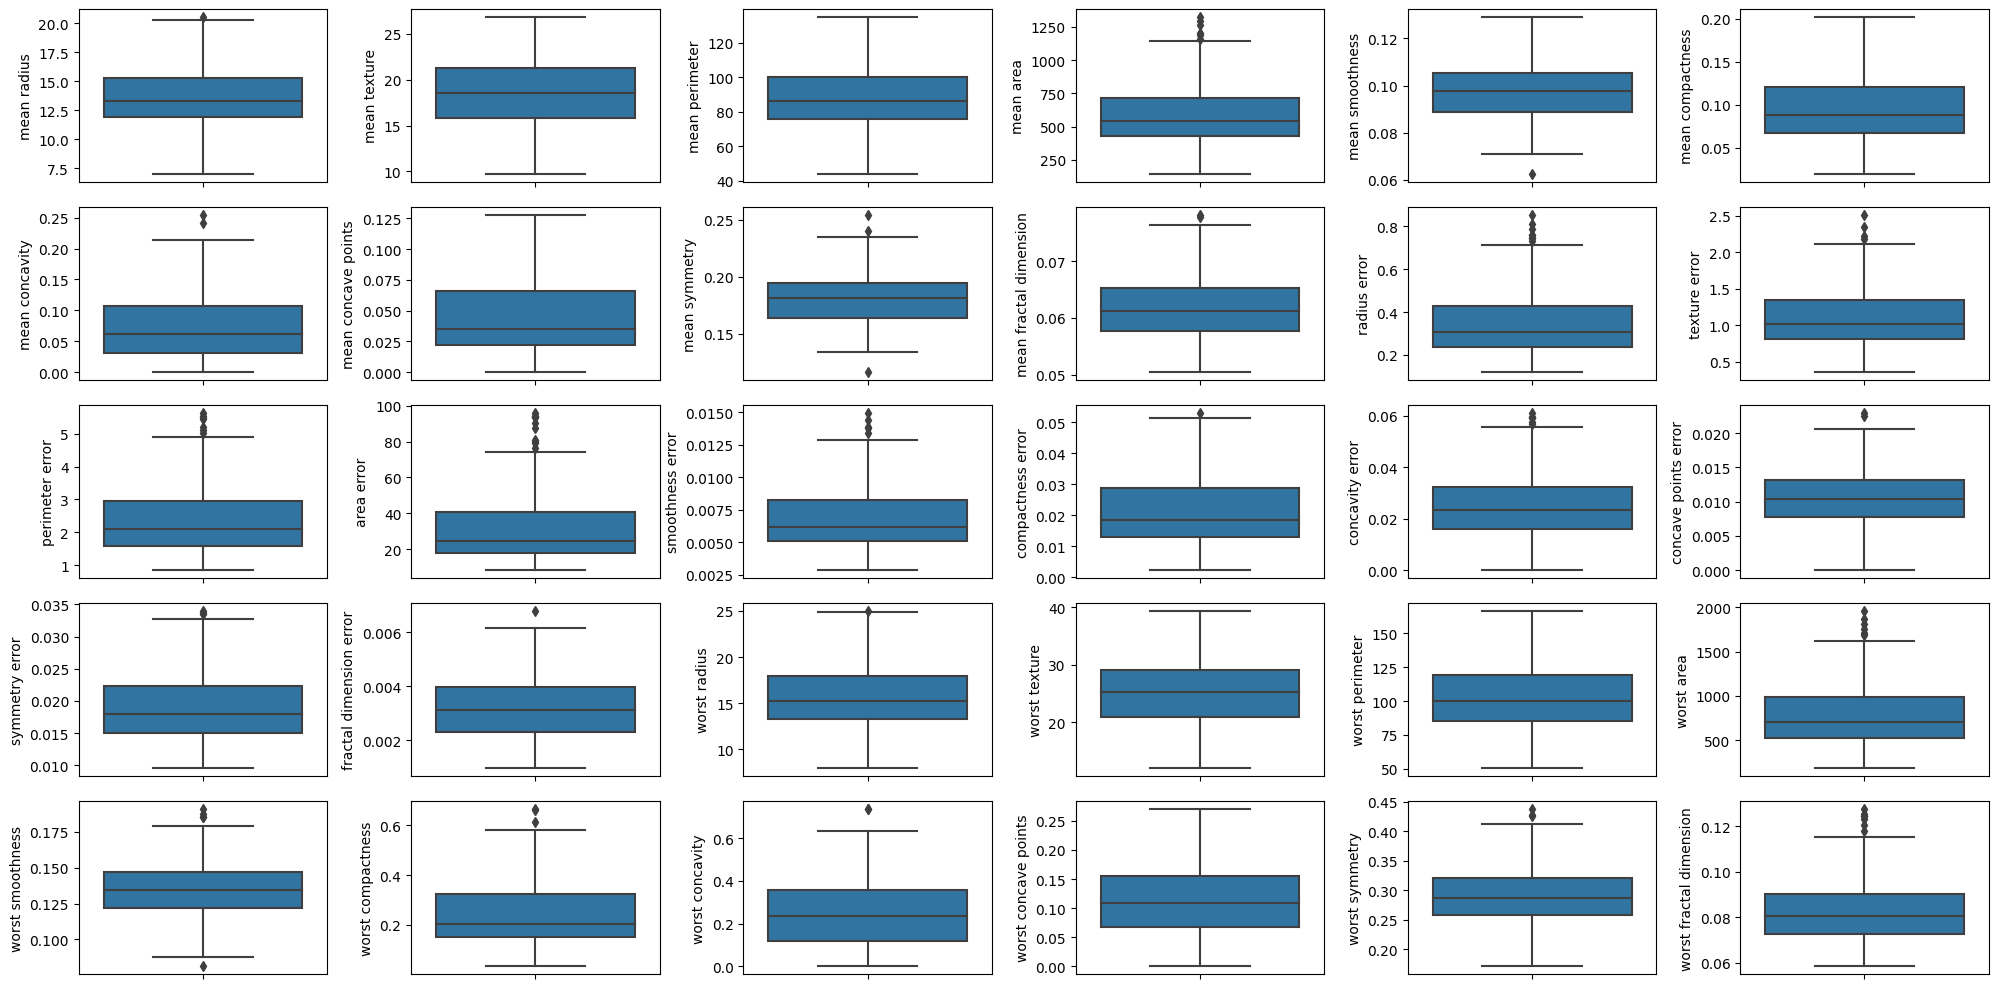

In [98]:
show_boxplot(X, X.columns)

Функция вывода графика корреляций

In [99]:
def plotCorrelationMatrix(df, graphWidth):
    #filename = df.dataframeName
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
#     print(corr)
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
#     print(corrMat)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    #plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.title(f'Матрица корреляции', fontsize=15)
    plt.show()

In [100]:
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

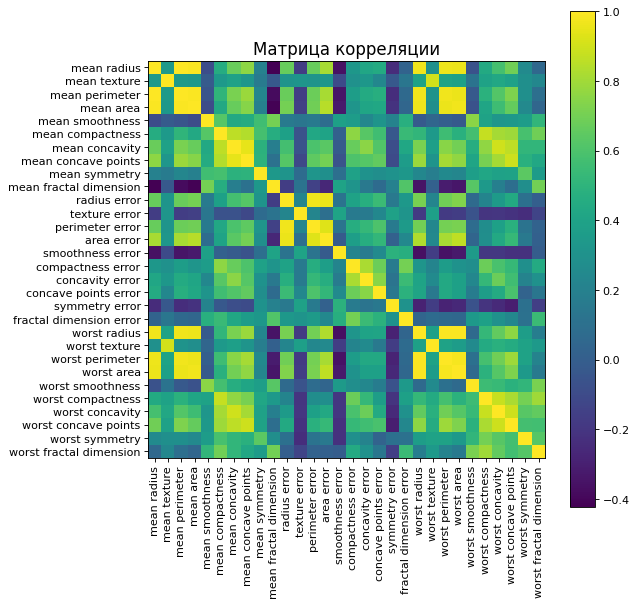

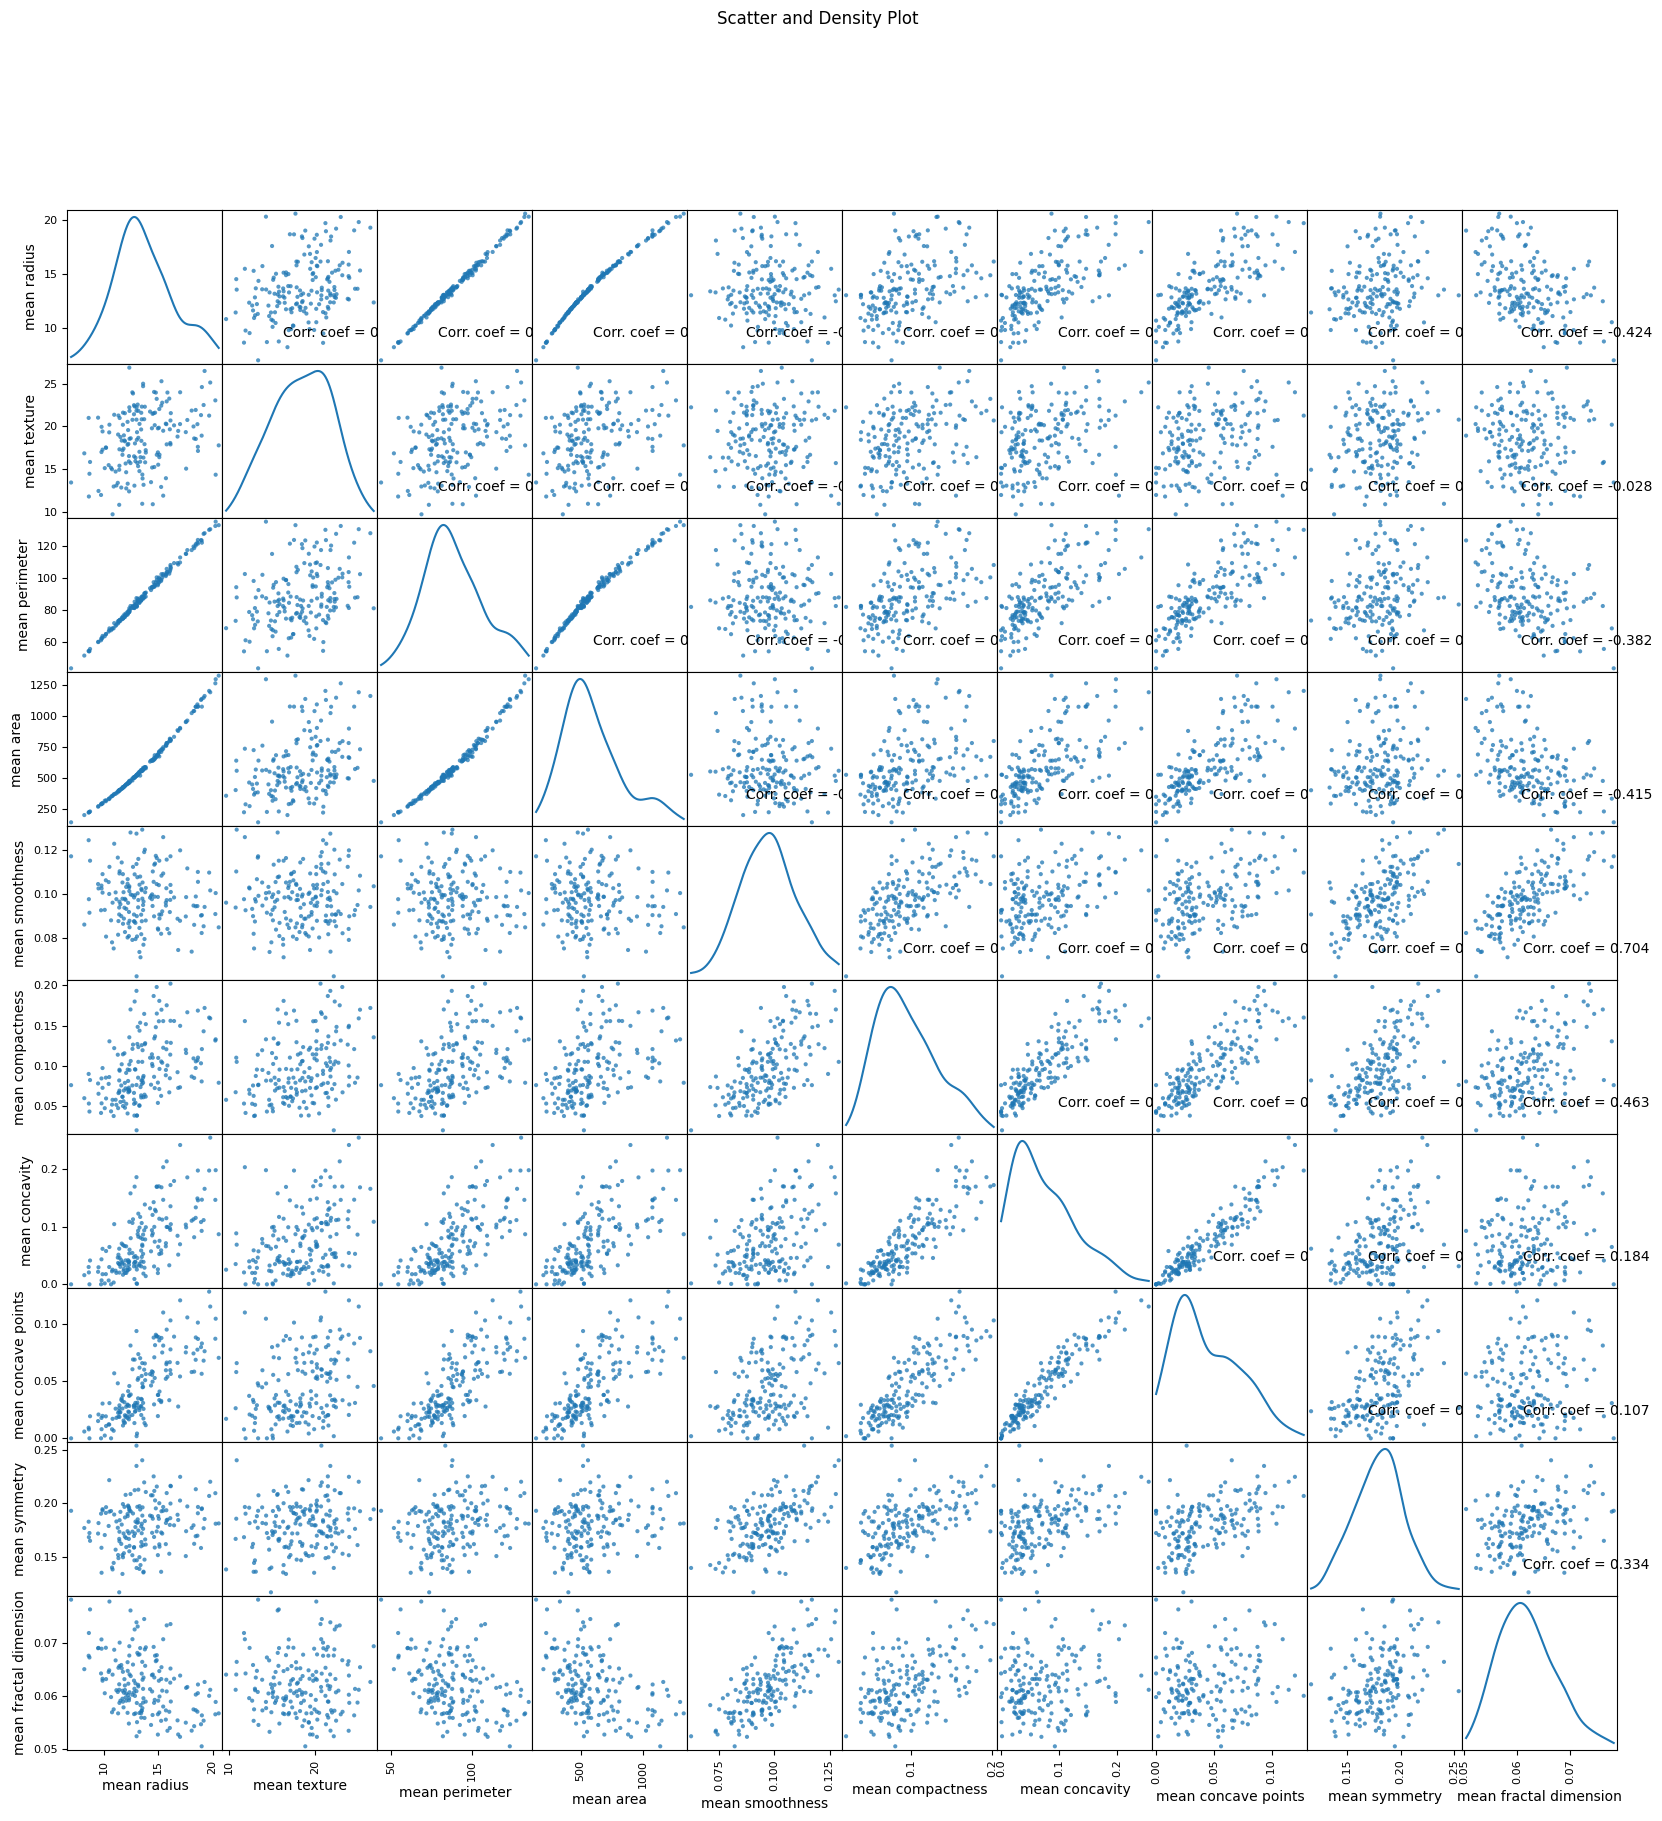

In [101]:
plotCorrelationMatrix(X, 8)
plotScatterMatrix(X, 20, 10)

In [102]:
X = X.drop(X.columns[[2, 3, 6, 22, 24]], axis =1)

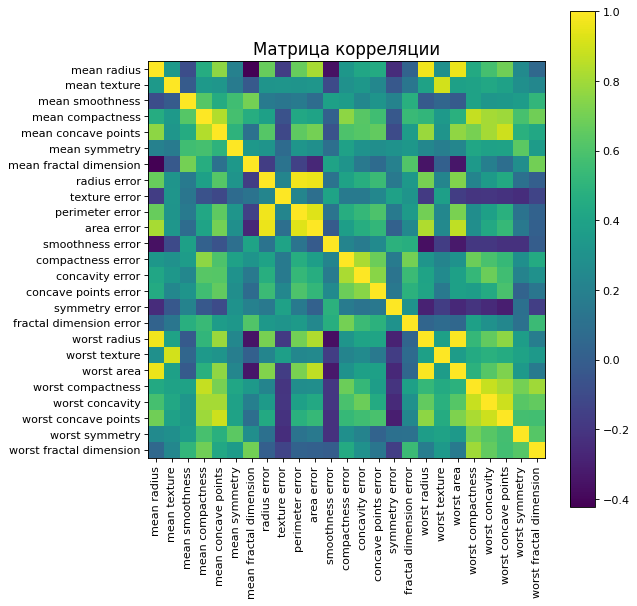

In [103]:
plotCorrelationMatrix(X, 8)

Данные для обучения и проверки

In [104]:
x_train, x_test, y_train, y_test = train_test_split(X, list(y['target']), test_size=.2)
print(len(x_train),len(x_test),len(y_train),len(y_test))

137 35 137 35


In [105]:
sc = StandardScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.fit_transform(x_test)

__KNN__

In [106]:
knn_model = KNeighborsClassifier()

knn_model.fit(x_train, y_train)

KNeighborsClassifier()

__DecisionTreeClassifier__

In [107]:
DTC_model = DecisionTreeClassifier()
DTC_model.fit(x_train, y_train)

DecisionTreeClassifier()

__Logistic regression__

In [108]:
LogisticReg_model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)

LogisticReg_model.fit(x_train, y_train)

LogisticRegression(max_iter=1000, random_state=12345)

__SVM__

In [109]:
svm_model = SVC(kernel='linear')
svm_model.fit(x_train, y_train)

SVC(kernel='linear')

In [110]:
def print_score(model, x_train, x_test):
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    print(f'Model {model.__class__.__name__} \n accuracy {accuracy_score(y_test, y_pred_test):0.4f}; \n f1 = {f1_score(y_test, y_pred_test):0.4f}; \n percison {precision_score(y_test, y_pred_test):0.4f}; \n recall {recall_score(y_test, y_test):0.4f}')
    print(f'confusion matrix \n {confusion_matrix(y_test, y_pred_test)}')
    print()
    print('Отчет по тренировочным данным')
    print(classification_report(y_train, y_pred_train))
    print()

    print('Отчет по тестовым данным')
    print(classification_report(y_test, y_pred_test))
    print()
    print('---------------')
    return [round(accuracy_score(y_test, y_pred_test), 4), round(f1_score(y_test, y_pred_test),4) ]

In [111]:
models = [knn_model, DTC_model, LogisticReg_model, svm_model]
list_accuracy_f1_mod1 = []

for mod in models:
    list_accuracy_f1_mod1.append(print_score(mod, x_train, x_test))

Model KNeighborsClassifier 
 accuracy 0.9714; 
 f1 = 0.9677; 
 percison 0.9375; 
 recall 1.0000
confusion matrix 
 [[19  1]
 [ 0 15]]

Отчет по тренировочным данным
              precision    recall  f1-score   support

           0       0.94      0.90      0.92        52
           1       0.94      0.96      0.95        85

    accuracy                           0.94       137
   macro avg       0.94      0.93      0.94       137
weighted avg       0.94      0.94      0.94       137


Отчет по тестовым данным
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.94      1.00      0.97        15

    accuracy                           0.97        35
   macro avg       0.97      0.97      0.97        35
weighted avg       0.97      0.97      0.97        35


---------------
Model DecisionTreeClassifier 
 accuracy 0.8571; 
 f1 = 0.8571; 
 percison 0.7500; 
 recall 1.0000
confusion matrix 
 [[15  5]
 [ 0 15]]

О

Генерация новых признаков с помощью библиотек tsfresh

In [112]:
X['id'] = list(range(X.shape[0]))
X.reset_index(drop= True , inplace= True)
y.reset_index(drop= True , inplace= True)

In [113]:
extracted_features = extract_relevant_features(X, y['target'], column_id='id')

Feature Extraction: 100%|███████████████████████| 20/20 [00:19<00:00,  1.01it/s]


Разделим данные с новыми признаками на обучающую и тестовую выборку

In [114]:
X_train_extracted, X_test_extracted, y_train, y_test = train_test_split(extracted_features, y, test_size=0.2)

Нормализуем данные

In [115]:
x_train_extracted_scaled = sc.fit_transform(X_train_extracted)
x_test_extracted_scaled = sc.transform(X_test_extracted)

Обучим модель на добавленных сгенерированных данных

In [116]:
DTC_model2 = DecisionTreeClassifier()
DTC_model2.fit(x_train_extracted_scaled, y_train)

DecisionTreeClassifier()

In [117]:
def feature_names_to_merge(model):
    importances = model.feature_importances_

    sorted_indices = np.argsort(importances)[::-1]

    feat_labels = extracted_features.columns[:]

    feature_names_to_merge = []
    feature_count_to_merge = 5

    for f in range(extracted_features.shape[1]):
        print("%2d) %-*s %f" % (f + 1, 30, feat_labels[sorted_indices[f]], importances[sorted_indices[f]]))
        if len(feature_names_to_merge) < feature_count_to_merge:
            feature_names_to_merge.append(feat_labels[sorted_indices[f]])
    return feature_names_to_merge

In [118]:
feature_names_to_merge = feature_names_to_merge(DTC_model2)

 1) worst area__quantile__q_0.3    0.729078
 2) mean texture__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20) 0.085292
 3) worst concave points__fft_coefficient__attr_"abs"__coeff_0 0.057413
 4) worst texture__abs_energy      0.056332
 5) perimeter error__abs_energy    0.042528
 6) worst concavity__minimum       0.029356
 7) area error__median             0.000000
 8) area error__quantile__q_0.3    0.000000
 9) area error__maximum            0.000000
10) area error__quantile__q_0.4    0.000000
11) area error__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20) 0.000000
12) area error__quantile__q_0.7    0.000000
13) area error__quantile__q_0.8    0.000000
14) area error__quantile__q_0.9    0.000000
15) area error__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20) 0.000000
16) area error__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20) 0.000000
17) area error__root_mean_square   0.000000
18) area error__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20) 0.000000


In [119]:
feature_names_to_merge 

['worst area__quantile__q_0.3',
 'mean texture__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)',
 'worst concave points__fft_coefficient__attr_"abs"__coeff_0',
 'worst texture__abs_energy',
 'perimeter error__abs_energy']

In [120]:
list_accuracy_f1_mod2 = print_score(DTC_model2, x_train_extracted_scaled, x_test_extracted_scaled)

Model DecisionTreeClassifier 
 accuracy 0.8857; 
 f1 = 0.9048; 
 percison 0.9500; 
 recall 1.0000
confusion matrix 
 [[12  1]
 [ 3 19]]

Отчет по тренировочным данным
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00        78

    accuracy                           1.00       137
   macro avg       1.00      1.00      1.00       137
weighted avg       1.00      1.00      1.00       137


Отчет по тестовым данным
              precision    recall  f1-score   support

           0       0.80      0.92      0.86        13
           1       0.95      0.86      0.90        22

    accuracy                           0.89        35
   macro avg       0.88      0.89      0.88        35
weighted avg       0.89      0.89      0.89        35


---------------


In [121]:
x_merged = X.copy()
x_merged[feature_names_to_merge] = extracted_features[feature_names_to_merge]

In [122]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              172 non-null    float64
 1   mean texture             172 non-null    float64
 2   mean smoothness          172 non-null    float64
 3   mean compactness         172 non-null    float64
 4   mean concave points      172 non-null    float64
 5   mean symmetry            172 non-null    float64
 6   mean fractal dimension   172 non-null    float64
 7   radius error             172 non-null    float64
 8   texture error            172 non-null    float64
 9   perimeter error          172 non-null    float64
 10  area error               172 non-null    float64
 11  smoothness error         172 non-null    float64
 12  compactness error        172 non-null    float64
 13  concavity error          172 non-null    float64
 14  concave points error     1

In [123]:
x_merged_train, x_merged_test, y_train, y_test = train_test_split(x_merged, y, test_size=0.2)

In [124]:
x_merged_train_scaled = sc.fit_transform(x_merged_train)
x_merged_test_scaled = sc.transform(x_merged_test)

In [125]:
DTC_model3 = DecisionTreeClassifier()

In [126]:
DTC_model3.fit(x_merged_train_scaled, y_train)

DecisionTreeClassifier()

In [127]:
list_accuracy_f1_mod3 = print_score(DTC_model3, x_merged_train_scaled, x_merged_test_scaled )

Model DecisionTreeClassifier 
 accuracy 0.9429; 
 f1 = 0.9500; 
 percison 0.9048; 
 recall 1.0000
confusion matrix 
 [[14  2]
 [ 0 19]]

Отчет по тренировочным данным
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        56
           1       1.00      1.00      1.00        81

    accuracy                           1.00       137
   macro avg       1.00      1.00      1.00       137
weighted avg       1.00      1.00      1.00       137


Отчет по тестовым данным
              precision    recall  f1-score   support

           0       1.00      0.88      0.93        16
           1       0.90      1.00      0.95        19

    accuracy                           0.94        35
   macro avg       0.95      0.94      0.94        35
weighted avg       0.95      0.94      0.94        35


---------------


In [128]:
print(list_accuracy_f1_mod1[1], list_accuracy_f1_mod2, list_accuracy_f1_mod3) 

[0.8571, 0.8571] [0.8857, 0.9048] [0.9429, 0.95]


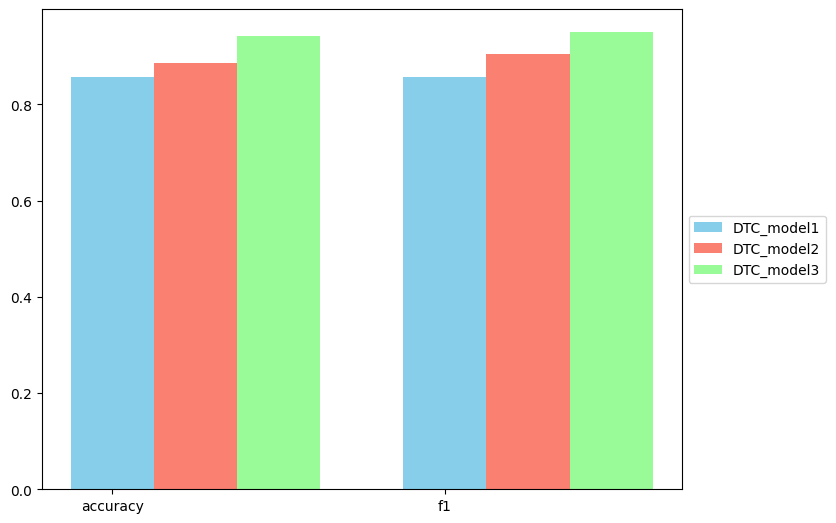

In [129]:
data = [list_accuracy_f1_mod1[1], list_accuracy_f1_mod2, list_accuracy_f1_mod3]
X = np.arange(2)
w = 0.25
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X, data[0], color = 'skyblue', width = w)
ax.bar(X + w, data[1], color = 'salmon', width = w)
ax.bar(X + 2*w, data[2], color = 'palegreen', width = w)
ax.set_xticks(X, ('accuracy', 'f1'))
ax.legend(labels=['DTC_model1', 'DTC_model2', 'DTC_model3'], bbox_to_anchor=(1, 0.5), loc = 'center left')
plt.show()

##### Улучшен результат обучения выбранной модели с помощью внедрения новых признаков.
Аccuracy увеличился с 0.86 до 0.94

F1 увеличился с 0.85 до 0.95